In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from pathlib import Path
##################################
HF_TOKEN = Path(".hf_token").read_text().strip() # or directly paste your token here
##################################
import sys
sys.path.append("./models")

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
timm.layers.set_fused_attn(False)

from prismatic import load

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load a pretrained VLM (either local path, or ID to auto-download from the HF Hub) 
model_id = "phi-2+3b"
vlm = load(model_id, hf_token=HF_TOKEN)
dtype = torch.bfloat16
if not torch.cuda.is_bf16_supported():
    vlm.llm_backbone.half_precision_dtype = torch.float16
    dtype = torch.float16
vlm.to(device, dtype=dtype);

06/03 [14:06:58] INFO     | >> [*] Downloading `phi-2+3b from HF Hub                                     ]8;id=657999;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py\load.py]8;;\:]8;id=64905;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py#63\63]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing phi-2+3b with:                    ]8;id=793376;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py\load.py]8;;\:]8;id=412361;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py#75\75]8;;\
                                       Vision Backbone =>> clip-vit-l-336px                                        
                                       LLM Backbone    =>> phi-2-3b                                                
                                       Arch Specifier  =>> no-align+gelu-mlp                                       
                                       Checkpoint Path =>>                                                         
                          `/home/jz288/.cache/huggingface/hub/models--TRI-ML--prismatic-vlms/snapshots/a           
                          3ba8a19c453a82eaf5a3fb1e699dd9e441f0a12/phi-2+3b/checkpoints/latest-checkpoint           
                          .pt`                                                                                     

                 INFO     | >> [*] Loading Vision Backbone clip-vit-l-336px                              ]8;id=628000;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py\load.py]8;;\:]8;id=63320;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py#84\84]8;;\

06/03 [14:07:03] INFO     | >> [*] Loading Pretrained LLM phi-2-3b via HF Transformers                   ]8;id=743863;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py\load.py]8;;\:]8;id=409949;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py#91\91]8;;\

                 INFO     | >>     |=> Building empty phi LLM from `microsoft/phi-2`                ]8;id=113631;file:///home/jz288/vlm_vis/./models/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=656043;file:///home/jz288/vlm_vis/./models/prismatic/models/backbones/llm/base_llm.py#130\130]8;;\

06/03 [14:07:34] INFO     | >>     |=> Loading phi (Fast) Tokenizer via the AutoTokenizer API       ]8;id=209702;file:///home/jz288/vlm_vis/./models/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=538906;file:///home/jz288/vlm_vis/./models/prismatic/models/backbones/llm/base_llm.py#147\147]8;;\

06/03 [14:07:37] INFO     | >> [*] Loading VLM phi-2+3b from Checkpoint; Freezing Weights 🥶            ]8;id=336273;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py\load.py]8;;\:]8;id=4353;file:///home/jz288/vlm_vis/./models/prismatic/models/load.py#100\100]8;;\

In [3]:
from PIL import Image
import requests

# Download an image and specify a prompt
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
user_prompt = "What is going on in this image?"

# Build prompt
prompt_builder = vlm.get_prompt_builder()
prompt_builder.add_turn(role="human", message=user_prompt)
prompt_text = prompt_builder.get_prompt()

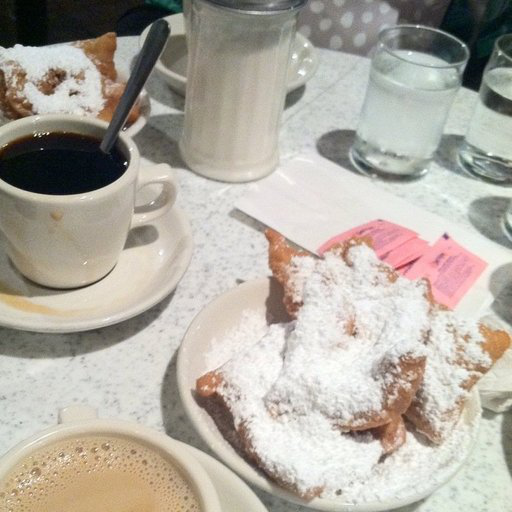

In [4]:
image

In [5]:
output = vlm.generate(
    image,
    prompt_text,
    do_sample=False,
    max_new_tokens=512,
    output_attentions=True,
    return_dict=True
)

tensor([[[ 0.4630, -0.0376,  0.6292,  ...,  0.5564,  0.9485,  0.4340],
         [-0.4728, -0.8873, -0.1276,  ...,  0.0925,  0.2928,  0.0047],
         [-0.3496, -0.4717,  0.3765,  ...,  0.6464,  0.4596, -0.1928],
         ...,
         [ 2.0372,  1.0284, -0.8986,  ...,  2.5970, -0.6161,  2.5705],
         [ 0.1113, -0.6655,  0.2165,  ...,  0.6084,  0.5146,  0.1084],
         [ 0.0589,  0.1563,  0.6646,  ...,  0.7277,  0.8148, -0.5151]]],
       device='cuda:0')
torch.Size([576, 1024])
